<a href="https://colab.research.google.com/github/subornaa/Data-Analytics-Tutorials/blob/main/Lasso_and_Ridge_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regularization Techniques: Lasso and Ridge Regression

# Introduction and Dataset

## Background

This tutorial will explore Lasso and Ridge regression methods to model different response variables that are commonly modeled in forestry. These include quadratic mean diameter (QMD), aboveground biomass (AGB), and basal area (BA). The tutorial will employ a suite of input features (i.e., predictor variables) used to estimate the response variables.

## Tutorial goals

**Goal 1: Develope ridge and lasso regression models for QMD, AGB, and BA using LiDAR and multispectral predictor variables**

**Goal 2: Compare ridge and lasso models for each response variable and choose the best model for each**

**Goal 3: Apply the best performing model for each response variable across the entire PRF**

-----

## Data

Please refer to the README on the main GitHub page for a detailed description of each file.


## Packages

- GeoPandas
- rioxarray
- spyndex

# Install and load packages

**Uncomment the cell below to install required packages**

In [1]:
!pip install pandas==2.2.2
!pip install geopandas==1.0.1
!pip install matplotlib==3.10.1
!pip install rioxarray==0.19.0
!pip install spyndex==0.5.0
!pip install pyarrow==19.0.0
!pip install laspy[lazrs]==2.5.4

  Using cached rioxarray-0.19.0-py3-none-any.whl.metadata (5.5 kB)
  Using cached rasterio-1.4.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (9.1 kB)
Using cached rioxarray-0.19.0-py3-none-any.whl (62 kB)
Using cached rasterio-1.4.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (22.2 MB)
  Using cached spyndex-0.5.0.tar.gz (727 kB)
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.7/134.7 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.7/224.7 kB 10.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for spyndex: filename=spyndex-0.5.0-py3-none-any.whl size=767321 sha256=1731d5e639d8204ed32dd8053b3e25af679a138bc29471eaf8d93e533d6e62c3
  Stored in directory: /root/.cache/pip/wheels/03/5d/7f/047b431b710b7165f2d2be752885f233acca8d8a7feffaae22
  Created wheel for eemont: filename=eemont-0.3.6-py3-none-any.whl size=135741 sha25

In [2]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import rioxarray as rio
import spyndex
import laspy
from spyndex import indices
from math import sqrt, pi
import matplotlib.pyplot as plt
from rasterio.plot import show
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# Download data

In [3]:
# Download the data if it does not yet exist
if not os.path.exists("data"):
  !gdown 1UDKAdXW0h6JSf7k31PZ-srrQ3487l9e2
  !unzip prf_data.zip -d data/
  os.remove("prf_data.zip")
else:
  print("Data has already been downloaded.")

os.listdir("data")

Downloading...
From (original): https://drive.google.com/uc?id=1UDKAdXW0h6JSf7k31PZ-srrQ3487l9e2
From (redirected): https://drive.google.com/uc?id=1UDKAdXW0h6JSf7k31PZ-srrQ3487l9e2&confirm=t&uuid=a15297cc-689f-4953-88ba-a4af6189bfac
To: /content/prf_data.zip
100% 150M/150M [00:07<00:00, 19.0MB/s]
Archive:  prf_data.zip
  inflating: data/boundary.gpkg      
  inflating: data/trees.csv          
  inflating: data/plots.gpkg         
  inflating: data/water.gpkg         
  inflating: data/als_metrics.tif    
  inflating: data/forest_point_cloud.las  
  inflating: data/forest_point_cloud_footprint.gpkg  
  inflating: data/petawawa_s2_2018.tif  
  inflating: data/petawawa_s2_2024.tif  


['plots.gpkg',
 'forest_point_cloud.las',
 'als_metrics.tif',
 'forest_point_cloud_footprint.gpkg',
 'petawawa_s2_2018.tif',
 'trees.csv',
 'water.gpkg',
 'boundary.gpkg',
 'petawawa_s2_2024.tif']

# Preprocessing

Before we can begin with ridge and lasso regression, we must first preprocess the data so it is analysis ready. The following code blocks will prepare both the response variables (QMD, AGB, BA) in addition to predictor variables (99th height percentile and spectral indices).

In [4]:
trees_df = gpd.read_file(r'data/trees.csv')
plots_gdf = gpd.read_file(r'data/plots.gpkg').rename(columns={"Plot": "PlotName"})

This block of code ensures that the `biomass`, `height`, `baha` and `DBH` columns in trees_df are numeric

In [5]:
cols_to_convert = ['biomass', 'height', 'baha', 'DBH']
for col in cols_to_convert:
    trees_df[col] = pd.to_numeric(trees_df[col])

trees_df

,PlotName,TreeID,species,Origin,Status,DBH,CrownClass,DecayClass,height,baha,codom,mvol,tvol,biomass,size
0,PRF001,24.0,White pine,P,D,10.1,,1.0,11.552521,0.128190,N,0.0,0.7087347141,393.396400,Poles
1,PRF001,46.0,White pine,P,D,9.9,,2.0,11.422529,0.123163,N,0.0,0.6732544319,375.305379,Poles
2,PRF001,20.0,Red pine,N,L,67.5,D,,33.900000,5.725566,Y,77.327438489,79.482658012,39691.639950,Large
3,PRF001,50.0,Red pine,N,L,57.9,D,,32.528851,4.212773,Y,56.444280856,58.117291913,28251.255888,Large
4,PRF001,10.0,White pine,N,L,55.9,D,,33.000000,3.926761,Y,48.008649036,49.833742798,24501.838779,Large
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12585,PRF334,,Sugar Maple,N,L,3.7,,,8.893640,0.215043,N,0.0,0.8585643577,851.191939,Under
12586,PRF334,,Sugar Maple,N,L,3.3,,,8.500000,0.171060,N,0.0,0.6538680809,659.084439,Under
12587,PRF334,,Sugar Maple,N,L,3.2,,,8.395967,0.160850,N,0.0,0.607492501,615.333049,Under
12588,PRF334,,Sugar Maple,N,L,3.0,,,7.400000,0.141372,N,0.0,0.4696555303,521.064025,Under


Lets check the range of various tree attributes, they seem good!

In [6]:
trees_df.describe()

,DBH,height,baha,biomass
count,12590.000000,12590.000000,12590.000000,12342.000000
mean,17.622415,15.883219,0.602011,3286.085532
std,11.559345,6.713323,0.895101,6305.457552
min,2.500000,1.301584,0.070686,138.409692
25%,10.600000,11.531384,0.174975,634.448847
50%,14.500000,14.907205,0.309749,1266.913205
75%,21.100000,19.398785,0.623451,2800.442589
max,97.500000,50.300000,11.945934,89100.864298


## Response Variables

Just as a refresher, this is the variable that is being measured, observed, or is the focus of the study. Its expcted to change in relation with other variables. Below is the exploration of the response variables we will be looking at

### Quadratic Mean Diameter

Quadratic Mean Diameter (QMD) is a common stand level attribute that is modeled in forestry. QMD is often prefered over the arithmetic mean in forestry because it gives greater weight to larger trees. This is relevant for several reasons, primarily though because the wood from larger trees is more valuable.

QMD also is relevant for understanding forest ecology among other applications.

              qmd
count  249.000000
mean    22.515733
std      7.292152
min      9.487689
25%     17.508306
50%     20.996809
75%     25.918597
max     58.166457


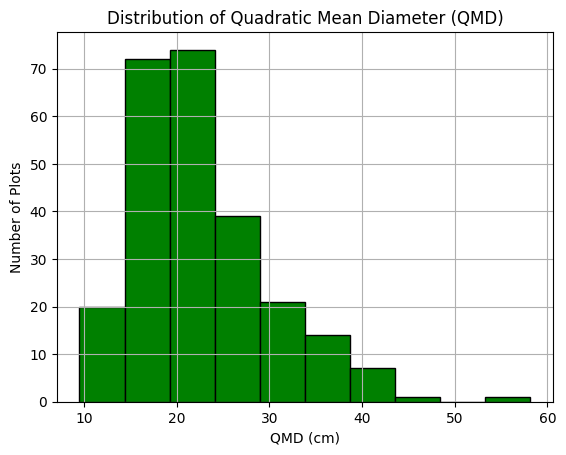

In [7]:
# Calculate the Quadratic Mean Diameter (QMD)
qmd_df = (
    trees_df
    .groupby('PlotName')
    .agg(
        n_trees=('DBH', 'count'),
        sum_squares=('DBH', lambda x: (x**2).sum())
    )
    .assign(qmd=lambda df: (df['sum_squares'] / df['n_trees']).apply(sqrt))
    .reset_index()[['PlotName', 'qmd']]
)

print(qmd_df.describe())

# Join with plots GeoDataFrame
plots_gdf = plots_gdf.merge(qmd_df, on='PlotName', how='left')

ax = plots_gdf['qmd'].hist(edgecolor='black', color='green')
ax.set_xlabel('QMD (cm)')
ax.set_ylabel('Number of Plots')
ax.set_title('Distribution of Quadratic Mean Diameter (QMD)')
plt.show()

### Aboveground Biomass (AGB)

Forest aboveground biomass (AGB) is another very common stand attribute to model. Biomass is defined as the living organic materials comprising trees including wood, bark, branches, foliage, etc. AGB is modeled for many different reasons. One relevant application of AGB modelling is for forest carbon projects, since forest aboveground carbon is typically estimated to be ~50% of AGB.

We can calculate plot-level AGB by summing the AGB of all trees in a plot, and then dividing that by the plot area. This is performed in the code below.

Area of each plot in hectares: 0.0625 ha
       biomass_Mg_total  biomass_Mg_ha
count        249.000000     249.000000
mean          10.179937     162.878987
std            5.571596      89.145529
min            0.146435       2.342960
25%            6.375452     102.007230
50%            9.263491     148.215860
75%           12.238090     195.809442
max           35.127161     562.034569


Text(0.5, 1.0, 'Distribution of Aboveground Biomass')

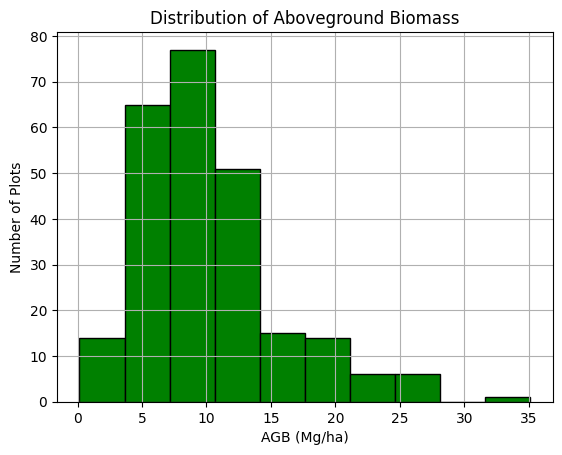

In [8]:
# Note that each plot has a radius of 14.1m (625m^2)
# We need to convert to hectares, since this is the most common areal unit in forestry.
# There are 10000 m^2 in a hectare, so we divide by 10000.

plot_area_m2 = 625

plot_area_ha = plot_area_m2 / 10000

print(f"Area of each plot in hectares: {plot_area_ha} ha")

# Convert tree-level biomass from Kg/ha to Kg, and then to Mg (tonnes).
trees_df['biomass_kg'] = trees_df['biomass'] * plot_area_ha
trees_df['biomass_Mg'] = trees_df['biomass_kg'] / 1000

biomass_df = (trees_df.groupby('PlotName').
                    agg(biomass_Mg_total=('biomass_Mg', 'sum')).
                    assign(biomass_Mg_ha=lambda x: x['biomass_Mg_total'] / plot_area_ha))

# Summarize biomass
print(biomass_df.describe())

# Join with plots GeoDataFrame
plots_gdf = plots_gdf.merge(biomass_df, on='PlotName', how='left')

ax = biomass_df['biomass_Mg_total'].hist(edgecolor='black', color='green')
ax.set_xlabel('AGB (Mg/ha)')
ax.set_ylabel('Number of Plots')
ax.set_title('Distribution of Aboveground Biomass')

### Basal Area

Basal Area represents the cross-sectional area of all trees per unit land area, It reflects how crowded or sparse a forest is, which is important for understanding growth conditions, competition, and habitat quality.


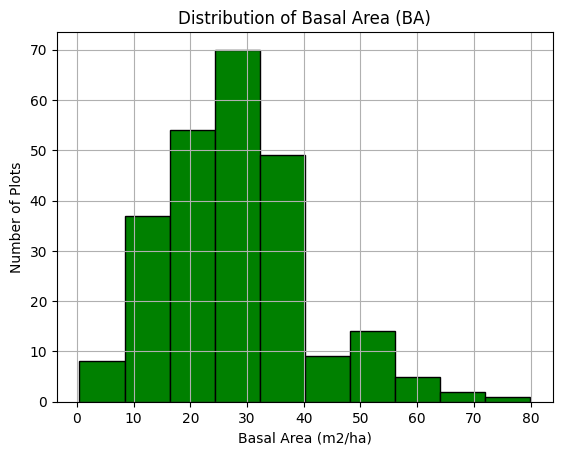

In [9]:
def get_ba(dbh):
    return ((dbh / 2) ** 2) * pi

ba_df = (trees_df
            .assign(ba_cm2=lambda x: get_ba(x['DBH']))
            .assign(ba_m2=lambda x: x['ba_cm2'] / 10000)
            .groupby('PlotName')
            .agg(total_ba_m2_ha=('ba_m2', 'sum'))
            .assign(ba_m2_ha=lambda x: x['total_ba_m2_ha'] / plot_area_ha)
            .reset_index())

ba_df.describe()

# Join with plots GeoDataFrame
plots_gdf = plots_gdf.merge(ba_df, on='PlotName', how='left')

ax = plots_gdf['ba_m2_ha'].hist(edgecolor='black', color='green')
ax.set_xlabel('Basal Area (m2/ha)')
ax.set_ylabel('Number of Plots')
ax.set_title('Distribution of Basal Area (BA)')
plt.show()

## Predictor Variables

This is the variable that is manipulated, controlled, or measured to see if it has an effect on the response variable. In our experiment, we would be trying to predict special indecies and ALS metrics.

### Airborne Laser Scanning (ALS) derived metrics.

We load the ALS metrics (ALS is a type of LiDAR) as an xarray dataset. xarray is similar to numpy arrays, but with added attributes and functionality. For example, xarrays can contain spatial coordinate reference systems (CRS).

Lets first read the `als_metrics`

In [10]:
als_metrics = rio.open_rasterio(r'data/als_metrics.tif')
als_metrics

<xarray.DataArray (band: 67, y: 366, x: 746)> Size: 73MB
[18293412 values with dtype=float32]
Coordinates:
  * band         (band) int64 536B 1 2 3 4 5 6 7 8 9 ... 60 61 62 63 64 65 66 67
  * x            (x) float64 6kB 2.974e+05 2.974e+05 ... 3.16e+05 3.16e+05
  * y            (y) float64 3kB 5.099e+06 5.099e+06 ... 5.09e+06 5.09e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     -3.4028235e+38
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      ('avg_95', 'avg', 'b10', 'b20', 'b30', 'b40', 'b50', 'b60...

Ensure that raster and plot coordinates are in the same CRS.

In [11]:
assert plots_gdf.crs == als_metrics.rio.crs, "CRS mismatch between plots and raster data."

Convert ALS metric names from a tuple to a list for later use.

In [12]:
als_metrics_nms = list(als_metrics.long_name)

**Question 1 - Next, we create a list of plot coordinate tuples by iterating through each ALS metric (by index) and extracting the value at each plot location.**

In [ ]:
plot_coords = [(geom.x, geom.y) for geom in plots_gdf.geometry]

for i, metric in enumerate(als_metrics_nms):

    #Uncomment the line below to see all the difference metrics
    #print(f"Extracting metric: {metric}")

    metric_ras_i = ...[i]
    plots_gdf[metric] = [float(metric_ras_i.sel(x=c[0], y=c[1], method="nearest").values) for c in plot_coords]

In [14]:
# @title Solution
plot_coords = [(geom.x, geom.y) for geom in plots_gdf.geometry]

for i, metric in enumerate(als_metrics_nms):

    #Uncomment the line below to see all the difference metrics
    #print(f"Extracting metric: {metric}")

    metric_ras_i = als_metrics[i]
    plots_gdf[metric] = [float(metric_ras_i.sel(x=c[0], y=c[1], method="nearest").values) for c in plot_coords]

Lets view the distribution of the 99th height percentile, it looks normal.

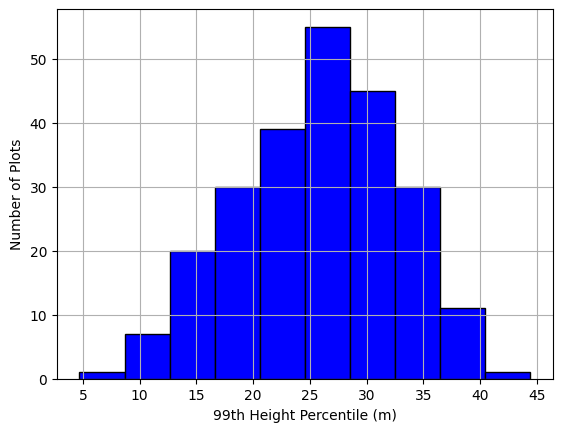

In [15]:
ax = plots_gdf['p99'].hist(edgecolor='black', color='blue')
ax.set_xlabel('99th Height Percentile (m)')
ax.set_ylabel('Number of Plots')
plt.show()

Now lets extract the spectral indices to use a predictor variables

### Sentinel-2 Spectral Indices

While we can write code to calculate spectral indices, this can become time consuming once we start dealing with many different indices. Moreover, we can make mistakes in our code. As a suitable alternative, the `spyndex` Python package offers a standardized, simpler method for calculating many spectral indices at once.

Read the spyndex documentation here: [https://spyndex.readthedocs.io/en/stable/](https://spyndex.readthedocs.io/en/stable/)

 First we load the Sentinel-2 imagery for 2018 (year the plots were sampled)

In [16]:
s2 = rio.open_rasterio(r'data/petawawa_s2_2018.tif')

assert plots_gdf.crs == s2.rio.crs, "CRS mismatch between plots and raster data."

# Consult the documentation for the spectral bands:
# https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR_HARMONIZED
s2


<xarray.DataArray (band: 12, y: 937, x: 1824)> Size: 82MB
[20509056 values with dtype=float32]
Coordinates:
  * band         (band) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
  * x            (x) float64 15kB 2.973e+05 2.973e+05 ... 3.155e+05 3.155e+05
  * y            (y) float64 7kB 5.099e+06 5.099e+06 ... 5.089e+06 5.089e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      ('B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', '...

Check range of reflectance for each band

In [17]:
print("Min reflectance in S2 data:", np.nanmin(s2.values))
print("Max reflectance in S2 data:", np.nanmax(s2.values))

Min reflectance in S2 data: 0.0013
Max reflectance in S2 data: 0.6144


**Consult this table for more details about band abbreviations used for spectral index calculation:**

[https://github.com/awesome-spectral-indices/awesome-spectral-indices?tab=readme-ov-file#expressions](https://github.com/awesome-spectral-indices/awesome-spectral-indices?tab=readme-ov-file#expressions)

In [18]:
print("Sentinel-2 band names order:", s2.long_name)
print("Spyndex band abbreviations:", spyndex.bands)

Sentinel-2 band names order: ('B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12')
Spyndex band abbreviations: ['A', 'B', 'G', 'G1', 'N', 'N2', 'R', 'RE1', 'RE2', 'RE3', 'S1', 'S2', 'T', 'T1', 'T2', 'WV', 'Y']


Make a list of spectral indices to calculate

In [19]:
spec_index_ls = ["NDVI", "NBR", "SAVI", "MSAVI", "DSI", "NDWI", "GLI",  "ND705", "NDREI", "IRECI", "TGI"]

One nice thing about spyndex is that it links each spectral index with a publication describing it. This code lists all the publications for each index

In [20]:
for si in spec_index_ls:
    print(f"{si}: {indices[si].reference}")

NDVI: https://ntrs.nasa.gov/citations/19740022614
NBR: https://doi.org/10.3133/ofr0211
SAVI: https://doi.org/10.1016/0034-4257(88)90106-X
MSAVI: https://doi.org/10.1016/0034-4257(94)90134-1
DSI: https://www.asprs.org/wp-content/uploads/pers/1999journal/apr/1999_apr_495-501.pdf
NDWI: https://doi.org/10.1080/01431169608948714
GLI: http://dx.doi.org/10.1080/10106040108542184
ND705: https://doi.org/10.1016/S0034-4257(02)00010-X
NDREI: https://doi.org/10.1016/1011-1344(93)06963-4
IRECI: https://doi.org/10.1016/j.isprsjprs.2013.04.007
TGI: http://dx.doi.org/10.1016/j.jag.2012.07.020


This code gets all the spectral indices

In [21]:
spec_indeces = spyndex.computeIndex(
    index = spec_index_ls,
    params = {
        "A": s2[0],
        "B": s2[1],
        "G": s2[2],
        "R": s2[3],
        "RE1": s2[4],
        "RE2": s2[5],
        "RE3": s2[6],
        "N": s2[7],
        "N2": s2[8],
        "WV": s2[9],
        "S1": s2[10],
        "S2": s2[11],
        "L": 1
    }

)

**Question 2 - Use the `spec_indeces` found before to extract the spectral indices into a dataframe.**

In [ ]:
for si_name in spec_index_ls:

    #Uncomment this line below to see the code extracting
    #print(f"Extracting {si_name} values at plot coordinates...")

    si_raster = ...[spec_indeces.index == si_name]

    plots_gdf[si_name] = [si_raster.sel(x=c[0], y=c[1], method="nearest").values[0] for c in plot_coords]

plots_gdf.head(5)

In [23]:
# @title Solution
for si_name in spec_index_ls:

    #Uncomment this line below to see the code extracting
    #print(f"Extracting {si_name} values at plot coordinates...")

    si_raster = spec_indeces[spec_indeces.index == si_name]

    plots_gdf[si_name] = [si_raster.sel(x=c[0], y=c[1], method="nearest").values[0] for c in plot_coords]

plots_gdf.head(5)

,PlotName,Date,Northing,Easting,Source,geometry,qmd,biomass_Mg_total,biomass_Mg_ha,total_ba_m2_ha,...,NBR,SAVI,MSAVI,DSI,NDWI,GLI,ND705,NDREI,IRECI,TGI
0,PRF208R,August 7 2018,5098426.096,312924.933,Topcon Hiper V PPP,POINT Z (312924.734 5098427.112 0),9.785100,0.876200,14.019203,0.248161,...,0.709994,0.488931,0.606115,0.387605,-0.750999,0.364300,0.547740,0.637373,1.063289,2.5840
1,PRF320,November 23 2018,5098579.361,312625.094,Topcon HiperSR PPP,POINT Z (312624.895 5098580.377 0),18.259018,8.952006,143.232099,1.492518,...,0.540868,0.356151,0.419385,0.590963,-0.709425,0.278922,0.500269,0.565841,0.659723,1.7700
2,PRF016,August 8 2018,5096992.483,313662.119,Topcon Hiper V PPP,POINT Z (313661.921 5096993.499 0),16.213670,6.809870,108.957923,1.465922,...,0.678063,0.422625,0.517317,0.407470,-0.762945,0.349233,0.577111,0.658688,0.940175,1.9025
3,PRF017,August 14 2018,5096896.098,313863.850,Topcon Hiper V PPP,POINT Z (313863.652 5096897.114 0),16.701949,4.659434,74.550945,0.942091,...,0.580265,0.323558,0.377138,0.545701,-0.709203,0.276740,0.502744,0.579135,0.585677,1.5210
4,PRF018,August 8 2018,5097138.299,313692.563,Topcon Hiper V PPP,POINT Z (313692.365 5097139.315 0),15.854214,6.700145,107.202327,1.263454,...,0.514979,0.296583,0.338885,0.609699,-0.652275,0.250350,0.446976,0.541924,0.420730,1.7405


Lets view one of the spectral indices.

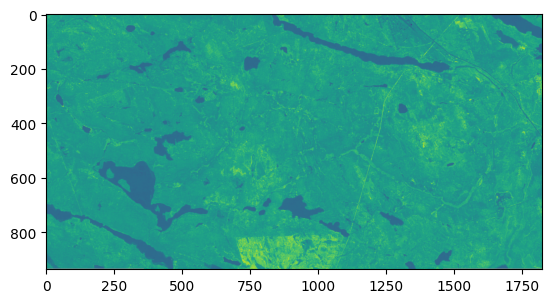

<Axes: >

In [24]:
view_si_nm = "NDVI"
view_si_raster = spec_indeces[spec_indeces.index == si_name]
show(view_si_raster.values[0], cmap='viridis')

Converting the geodataframe to regular dataframe allows for easier manipulation.

In [25]:
plots_df = pd.DataFrame(plots_gdf)
plots_df.head()

,PlotName,Date,Northing,Easting,Source,geometry,qmd,biomass_Mg_total,biomass_Mg_ha,total_ba_m2_ha,...,NBR,SAVI,MSAVI,DSI,NDWI,GLI,ND705,NDREI,IRECI,TGI
0,PRF208R,August 7 2018,5098426.096,312924.933,Topcon Hiper V PPP,POINT Z (312924.734 5098427.112 0),9.785100,0.876200,14.019203,0.248161,...,0.709994,0.488931,0.606115,0.387605,-0.750999,0.364300,0.547740,0.637373,1.063289,2.5840
1,PRF320,November 23 2018,5098579.361,312625.094,Topcon HiperSR PPP,POINT Z (312624.895 5098580.377 0),18.259018,8.952006,143.232099,1.492518,...,0.540868,0.356151,0.419385,0.590963,-0.709425,0.278922,0.500269,0.565841,0.659723,1.7700
2,PRF016,August 8 2018,5096992.483,313662.119,Topcon Hiper V PPP,POINT Z (313661.921 5096993.499 0),16.213670,6.809870,108.957923,1.465922,...,0.678063,0.422625,0.517317,0.407470,-0.762945,0.349233,0.577111,0.658688,0.940175,1.9025
3,PRF017,August 14 2018,5096896.098,313863.850,Topcon Hiper V PPP,POINT Z (313863.652 5096897.114 0),16.701949,4.659434,74.550945,0.942091,...,0.580265,0.323558,0.377138,0.545701,-0.709203,0.276740,0.502744,0.579135,0.585677,1.5210
4,PRF018,August 8 2018,5097138.299,313692.563,Topcon Hiper V PPP,POINT Z (313692.365 5097139.315 0),15.854214,6.700145,107.202327,1.263454,...,0.514979,0.296583,0.338885,0.609699,-0.652275,0.250350,0.446976,0.541924,0.420730,1.7405


Now that we have gathered all the necessary information, we can finalize our dataset by creating lists of all predictor and response variables.  
**Note:** In Python, two lists can be concatenated using the `+` operator.  
Please keep in mind that the predictor variables are distributed across two DataFrames: `spec_index_ls` and `als_metrics_nms`.


**Question 3 - fill in the code below.**

In [ ]:
predictor_vars = ... + ...
print("Predictor variables:", predictor_vars)

response_vars = ["biomass_Mg_ha", "ba_m2_ha", "qmd"]
print("Response variables:", response_vars)

In [26]:
# @title Solution
predictor_vars = spec_index_ls + als_metrics_nms
print("Predictor variables:", predictor_vars)

response_vars = ["biomass_Mg_ha", "ba_m2_ha", "qmd"]
print("Response variables:", response_vars)

Predictor variables: ['NDVI', 'NBR', 'SAVI', 'MSAVI', 'DSI', 'NDWI', 'GLI', 'ND705', 'NDREI', 'IRECI', 'TGI', 'avg_95', 'avg', 'b10', 'b20', 'b30', 'b40', 'b50', 'b60', 'b70', 'b80', 'b90', 'dns_10m', 'dns_12m', 'dns_14m', 'dns_15m', 'dns_16m', 'dns_18m', 'dns_20m', 'dns_25m', 'dns_2m', 'dns_4m', 'dns_5m', 'dns_6m', 'dns_8m', 'kur_95', 'p01', 'p05', 'p10', 'p20', 'p30', 'p40', 'p50', 'p60', 'p70', 'p80', 'p90', 'p95', 'p99', 'qav', 'skew_95', 'd0_2', 'd10_12', 'd12_14', 'd14_16', 'd16_18', 'd18_20', 'd20_22', 'd22_24', 'd24_26', 'd26_28', 'd28_30', 'd2_4', 'd30_32', 'd32_34', 'd34_36', 'd36_38', 'd38_40', 'd40_42', 'd42_44', 'd44_46', 'd46_48', 'd4_6', 'd6_8', 'd8_10', 'std_95', 'vci_1mbin', 'vci_0.5bin']
Response variables: ['biomass_Mg_ha', 'ba_m2_ha', 'qmd']


It is always good practice to ensure that there are no unexpected NaN values in the dataset.  
To do this, remove any rows containing NaN values in the predictor or response variables using the `dropna()` function.

In [27]:
plots_df = plots_df.dropna(subset=response_vars + predictor_vars)
plots_df.shape

(239, 89)

Let's examine the correlation matrix of the predictor and response variables.  
We primarily do this to identify any unusual or unexpected relationships in the data that may indicate issues or outliers.

In [28]:
corr_matrix = plots_df[response_vars + predictor_vars].corr()
corr_matrix

,biomass_Mg_ha,ba_m2_ha,qmd,NDVI,NBR,SAVI,MSAVI,DSI,NDWI,GLI,...,d40_42,d42_44,d44_46,d46_48,d4_6,d6_8,d8_10,std_95,vci_1mbin,vci_0.5bin
biomass_Mg_ha,1.000000,0.914255,0.535914,0.093842,0.200617,0.074345,0.067442,-0.206647,-0.132355,-0.026347,...,0.180204,0.175293,0.175293,0.175293,-0.357623,-0.326550,-0.304588,0.373794,0.197033,0.204754
ba_m2_ha,0.914255,1.000000,0.389644,0.038703,0.239056,-0.080360,-0.083297,-0.264476,-0.068731,-0.131092,...,0.144544,0.141415,0.141415,0.141415,-0.324034,-0.205984,-0.140529,0.235472,0.275512,0.280126
qmd,0.535914,0.389644,1.000000,-0.150855,-0.180031,-0.000869,-0.016822,0.190720,0.078660,-0.144257,...,0.158974,0.153131,0.153131,0.153131,-0.384423,-0.410504,-0.398955,0.582865,-0.256560,-0.246888
NDVI,0.093842,0.038703,-0.150855,1.000000,0.856760,0.836805,0.846581,-0.805253,-0.895448,0.835415,...,-0.009927,-0.006702,-0.006702,-0.006702,-0.049338,0.076836,0.121188,-0.386174,0.334287,0.390578
NBR,0.200617,0.239056,-0.180031,0.856760,1.000000,0.685963,0.693453,-0.982826,-0.809509,0.630777,...,-0.015109,-0.013062,-0.013062,-0.013062,-0.039172,0.163813,0.230483,-0.370044,0.377606,0.423200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
d6_8,-0.326550,-0.205984,-0.410504,0.076836,0.163813,-0.028344,-0.025835,-0.179205,-0.016325,0.077263,...,-0.022038,-0.019802,-0.019802,-0.019802,0.680582,1.000000,0.695121,-0.413712,0.139755,0.144337
d8_10,-0.304588,-0.140529,-0.398955,0.121188,0.230483,0.012181,0.014714,-0.247571,-0.055454,0.102985,...,-0.026527,-0.024305,-0.024305,-0.024305,0.287278,0.695121,1.000000,-0.460669,0.166322,0.177571
std_95,0.373794,0.235472,0.582865,-0.386174,-0.370044,-0.323882,-0.330801,0.356168,0.235313,-0.456881,...,0.172659,0.165714,0.165714,0.165714,-0.235786,-0.413712,-0.460669,1.000000,-0.067088,-0.095639
vci_1mbin,0.197033,0.275512,-0.256560,0.334287,0.377606,0.028549,0.041252,-0.390876,-0.259506,0.114473,...,0.073803,0.074019,0.074019,0.074019,0.180887,0.139755,0.166322,-0.067088,1.000000,0.992041


Let's take a quick look at our data.  
While we cannot identify any clear trends from this variable alone, we can explore what insights might be gained using Lasso and Ridge regression techniques.

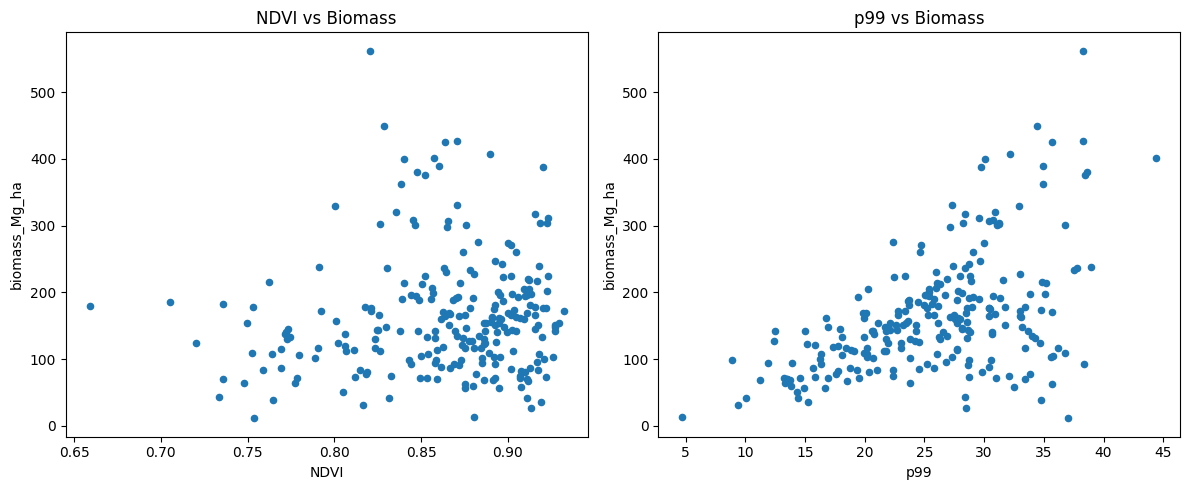

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# First plot: NDVI vs biomass
plots_df.plot.scatter(x='NDVI', y='biomass_Mg_ha', ax=axes[0])
axes[0].set_title('NDVI vs Biomass')

# Second plot: p99 vs biomass
plots_df.plot.scatter(x='p99', y='biomass_Mg_ha', ax=axes[1])
axes[1].set_title('p99 vs Biomass')

plt.tight_layout()
plt.show()

In [30]:
# Export plots with predictor variables for later use
plots_df[['PlotName'] + predictor_vars].to_csv('data/predictors.csv', index=False)

# Goal 1: Develope ridge and lasso regression models for QMD, AGB, and BA using LiDAR and multispectral predictor variables

To understand the purpose of the required packages:

- `train_test_split` is used to divide the dataset into training and testing sets. This helps us evaluate our model on "unseen" data, simulating how it would perform in real-world scenarios and reducing the risk of overfitting.

- `Lasso` is a linear regression model with L1 regularization. It adds a penalty that shrinks less important feature coefficients to zero, effectively performing feature selection. This improves model interpretability and helps prevent overfitting.

- `mean_squared_error` and `r2_score` are evaluation metrics.
    - mean_squared_error measures the average squared difference between actual and predicted values.

    - r2_score (coefficient of determination) indicates how well the model explains the variance in the target variable.




In [31]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score

Now that the setup is complete, we will define our target variable as `biomass_Mg_ha` and extract the predictor (`X`) and target (`y`) datasets accordingly.

Next, we will split the data into training and testing sets, reserving the test set for final model evaluation on unseen data.

**Question 1 - fill in the code below.**

In [ ]:
# Set target variable
target_var = "biomass_Mg_ha"

# Divide features and targets into separate DataFrames
X = plots_gdf[...]
y = plots_gdf[...]

# Split data into training and testing sets
X_train, X_test, ..., y_test = ...(X, y, test_size=0.3, random_state=42)

In [32]:
# @title Solution
# Set target variable
target_var = "biomass_Mg_ha"

# Divide features and targets into separate DataFrames
X = plots_gdf[predictor_vars]
y = plots_gdf[target_var]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

This block of code isn't strictly necessary for every experiment, but it serves as a final check to ensure data quality. It verifies that the dataset dimensions are consistent and that there are no unwanted NaN values before training the model.

In [33]:
train_df = pd.concat([X_train, y_train], axis=1)
train_df_clean = train_df.dropna()

# Separate features and target again
X_train = train_df_clean[predictor_vars]
y_train = train_df_clean[target_var]

Now we can finally train the model!

**Question 2 - fill in the code below.**

In [ ]:
# Train a lasso regression model with initial alpha=0.1
lasso = ...(alpha=0.99, max_iter=100000)
lasso....(X_train, y_train)

In [34]:
# @title Solution
# Train a lasso regression model with initial alpha=0.1
lasso = Lasso(alpha=0.99, max_iter=100000)
lasso.fit(X_train, y_train)

Lasso(alpha=0.99, max_iter=100000)

Once we train the model, we can use the test set as a true test of how accruate the model is.

In [35]:
test_df = pd.concat([X_test, y_test], axis=1)
test_df_clean = test_df.dropna()

# Separate features and target again
X_test = test_df_clean[predictor_vars]
y_test = test_df_clean[target_var]

y_test_pred_lasso = lasso.predict(X_test)

**Question 3 - Fill in the code below to get the R² and RMSE values.**

In [ ]:
# Calculate R2 and RMSE
r2 = ...(y_test, ...)
rmse = sqrt(....(y_test, ...))
print(f"R2: {r2:.3f}, RMSE: {rmse:.3f}")

In [36]:
# @title Solution
# Calculate R2 and RMSE
r2 = r2_score(y_test, y_test_pred_lasso)
rmse = sqrt(mean_squared_error(y_test, y_test_pred_lasso))
print(f"R2: {r2:.3f}, RMSE: {rmse:.3f}")

R2: 0.465, RMSE: 74.039


We can print out all the model coefficients to observe which penalties the Lasso model applied to each predictor.  
This provides insight into which variables the model considered most important.  
However, this information becomes more meaningful when compared to another model, so let's proceed by creating a Ridge regression model next.

In [37]:
# View the parameters of the model
print("Lasso coefficients:")
for feature, coef in zip(X.columns, lasso.coef_):
    print(f"{feature}: {coef:.4f}")

Lasso coefficients:
NDVI: -0.0000
NBR: 0.0000
SAVI: -0.0000
MSAVI: -0.0000
DSI: -0.0000
NDWI: 0.0000
GLI: -0.0000
ND705: -0.0000
NDREI: -0.0000
IRECI: -50.8468
TGI: 0.0000
avg_95: 0.0000
avg: 0.0000
b10: -0.7523
b20: -0.1559
b30: -0.5035
b40: -0.0000
b50: -0.2463
b60: 1.5188
b70: -0.0000
b80: -1.7058
b90: 0.9595
dns_10m: -0.0000
dns_12m: -0.0000
dns_14m: -0.0000
dns_15m: 0.0000
dns_16m: -0.0000
dns_18m: 0.8496
dns_20m: 0.0000
dns_25m: -1.1958
dns_2m: -0.2612
dns_4m: 0.0000
dns_5m: -0.0000
dns_6m: -0.6527
dns_8m: -0.0000
kur_95: 1.6553
p01: 3.4389
p05: -1.6053
p10: 1.3485
p20: 0.8939
p30: -0.0000
p40: 1.1882
p50: -1.3202
p60: 1.3965
p70: 1.7308
p80: -1.3629
p90: -0.0000
p95: -0.0000
p99: 1.5826
qav: 0.2664
skew_95: -14.7244
d0_2: 0.3449
d10_12: -0.0000
d12_14: -0.2275
d14_16: 1.4271
d16_18: -0.9439
d18_20: 0.0000
d20_22: 0.0000
d22_24: -4.0741
d24_26: 0.4517
d26_28: -0.0000
d28_30: 4.2909
d2_4: -1.7464
d30_32: -6.7537
d32_34: 6.0114
d34_36: -0.0000
d36_38: 3.5257
d38_40: -0.0000
d40_42:

`Ridge` regression is a linear regression model that includes L2 regularization.

In [38]:
from sklearn.linear_model import Ridge

Since our datasets are already prepared, we can train a Ridge regression model directly without any additional setup.

In [ ]:
# Train a ridge regression model with initial alpha=1
ridge = ...(alpha=1, max_iter=10000)
ridge....(..., ...)

In [39]:
# @title Solution
# Train a ridge regression model with initial alpha=1
ridge = Ridge(alpha=1, max_iter=10000)
ridge.fit(X_train, y_train)

Ridge(alpha=1, max_iter=10000)

Lets look at the metrics again, we will comapre them to the lasso matrics in goal 2!

In [ ]:
y_test_pred_ridge = ridge....(...)
# Calculate R2 and RMSE
r2 = r2_score(..., ...)
rmse = sqrt(mean_squared_error(..., ...))
print(f"R2: {r2:.3f}, RMSE: {rmse:.3f}")

In [40]:
# @title Solution
y_test_pred_ridge = ridge.predict(X_test)
# Calculate R2 and RMSE
r2 = r2_score(y_test, y_test_pred_ridge)
rmse = sqrt(mean_squared_error(y_test, y_test_pred_ridge))
print(f"R2: {r2:.3f}, RMSE: {rmse:.3f}")

R2: 0.260, RMSE: 87.045


Notice that none of the coefficients are exactly zero.  
This is a characteristic of Ridge regression, which will be discussed in more detail in the next objective.

In [41]:
print("ridge coefficients:")
for feature, coef in zip(X.columns, ridge.coef_):
    print(f"{feature}: {coef:.4f}")

ridge coefficients:
NDVI: -3.2522
NBR: 26.6794
SAVI: -3.3267
MSAVI: -7.6563
DSI: -37.8284
NDWI: 2.9425
GLI: -9.0081
ND705: -7.5383
NDREI: -0.0083
IRECI: -71.1947
TGI: 10.2474
avg_95: 14.8456
avg: 20.8826
b10: -1.7881
b20: -0.7827
b30: -0.1267
b40: 1.0077
b50: -2.1010
b60: 3.2297
b70: -1.1668
b80: -1.3018
b90: 0.4424
dns_10m: -0.5551
dns_12m: -0.0342
dns_14m: -0.0342
dns_15m: 0.8572
dns_16m: 4.5926
dns_18m: -1.9408
dns_20m: 5.8110
dns_25m: -12.4233
dns_2m: -6.9620
dns_4m: -2.9614
dns_5m: 11.8074
dns_6m: -8.5539
dns_8m: -8.5539
kur_95: 0.0043
p01: 7.6175
p05: -1.2765
p10: 2.3968
p20: 2.3461
p30: 1.9539
p40: 6.5492
p50: -2.9506
p60: 8.0298
p70: 5.3554
p80: 2.6060
p90: 4.7929
p95: 3.4817
p99: 4.5421
qav: -0.1426
skew_95: -34.5489
d0_2: 3.4402
d10_12: 9.3425
d12_14: 7.1942
d14_16: 8.9247
d16_18: -1.1647
d18_20: 2.3166
d20_22: -3.5830
d22_24: -12.4920
d24_26: 0.5639
d26_28: 3.1268
d28_30: 9.8986
d2_4: 4.3106
d30_32: -10.6603
d32_34: 18.0860
d34_36: -21.5194
d36_38: 20.8332
d38_40: 2.6660
d40

# Goal 2: Comapre the models.

Lets first try to look at the preformance of both models.

**Question 1 - Fill in the code below.**

In [ ]:
plt.figure(figsize=(12, 5))

# Ridge
plt.subplot(1, 2, 1)
plt.scatter(..., ..., alpha=0.6, color='royalblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Ridge Regression")

# Lasso
plt.subplot(1, 2, 2)
plt.scatter(y_test, ..., alpha=0.6, color='darkorange')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Lasso Regression")

plt.tight_layout()
plt.show()

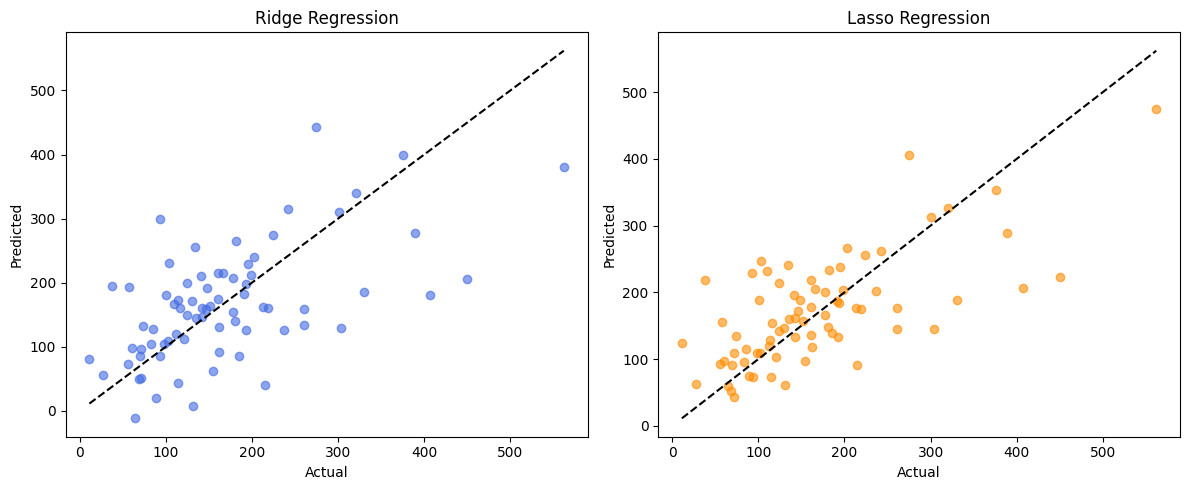

In [42]:
# @title Solution
plt.figure(figsize=(12, 5))

# Ridge
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_test_pred_ridge, alpha=0.6, color='royalblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Ridge Regression")

# Lasso
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_pred_lasso, alpha=0.6, color='darkorange')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Lasso Regression")

plt.tight_layout()
plt.show()

These type of graphs displays how closely the model's predictions align with the actual values.  
A perfect model would have all points lying on the dashed line.  
In this case, both models appear to perform similarly, so a closer examination is required to determine which model is superior.  
However, it appears that the Lasso model may have a slight advantage, though additional evidence is needed to support this conclusion.

One approach is to examine the coefficients of each model to glean insights about the relative importance of the predictors.

**Question 2 - fill in the code below.**

In [ ]:
feature_names =  ['NDVI', 'NBR', 'SAVI', 'MSAVI', 'DSI', 'NDWI', 'GLI', 'ND705', 'NDREI', 'IRECI', 'TGI', 'avg_95', 'avg', 'b10', 'b20', 'b30', 'b40', 'b50', 'b60', 'b70', 'b80', 'b90', 'dns_10m', 'dns_12m', 'dns_14m', 'dns_15m', 'dns_16m', 'dns_18m', 'dns_20m', 'dns_25m', 'dns_2m', 'dns_4m', 'dns_5m', 'dns_6m', 'dns_8m', 'kur_95', 'p01', 'p05', 'p10', 'p20', 'p30', 'p40', 'p50', 'p60', 'p70', 'p80', 'p90', 'p95', 'p99', 'qav', 'skew_95', 'd0_2', 'd10_12', 'd12_14', 'd14_16', 'd16_18', 'd18_20', 'd20_22', 'd22_24', 'd24_26', 'd26_28', 'd28_30', 'd2_4', 'd30_32', 'd32_34', 'd34_36', 'd36_38', 'd38_40', 'd40_42', 'd42_44', 'd44_46', 'd46_48', 'd4_6', 'd6_8', 'd8_10', 'std_95', 'vci_1mbin', 'vci_0.5bin']

ridge_coef = ridge....
lasso_coef = lasso....

x = np.arange(len(feature_names))
width = 0.35

fig, axes = plt.subplots(1, 2, figsize=(24, 10))

# Plot 1
# Use axes[0] for the first subplot
axes[0].bar(x - width/2, ridge_coef, width, label='Ridge')
axes[0].bar(x + width/2, lasso_coef, width, label='Lasso')
axes[0].set_ylabel("Coefficient Value")
axes[0].set_title("Model Coefficient Comparison (All Features - Rotated Labels)")
axes[0].legend()


# Prep data for top 20 coefs
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Ridge_Coef': ridge_coef,
    'Lasso_Coef': lasso_coef
})

coef_df['Abs_Sum_Coef'] = np.abs(coef_df['Ridge_Coef']) + np.abs(coef_df['Lasso_Coef'])
coef_df = coef_df.sort_values(by='Abs_Sum_Coef', ascending=False).head(25)

top_feature_names = coef_df['Feature'].tolist()
top_ridge_coef = coef_df['Ridge_Coef'].tolist()
top_lasso_coef = coef_df['Lasso_Coef'].tolist()

x_top = np.arange(len(top_feature_names))

# Plot 2
# Use axes[1] for the second subplot
axes[1].barh(x_top - width/2, top_ridge_coef, width, label='Ridge')
axes[1].barh(x_top + width/2, top_lasso_coef, width, label='Lasso')

axes[1].set_xlabel("Coefficient Value")
axes[1].set_ylabel("Feature Name")
axes[1].set_title("Model Coefficient Comparison (Top 25 Features)")
axes[1].legend()
axes[1].set_yticks(x_top)
axes[1].set_yticklabels(top_feature_names, fontsize=10)

plt.tight_layout()
plt.show()

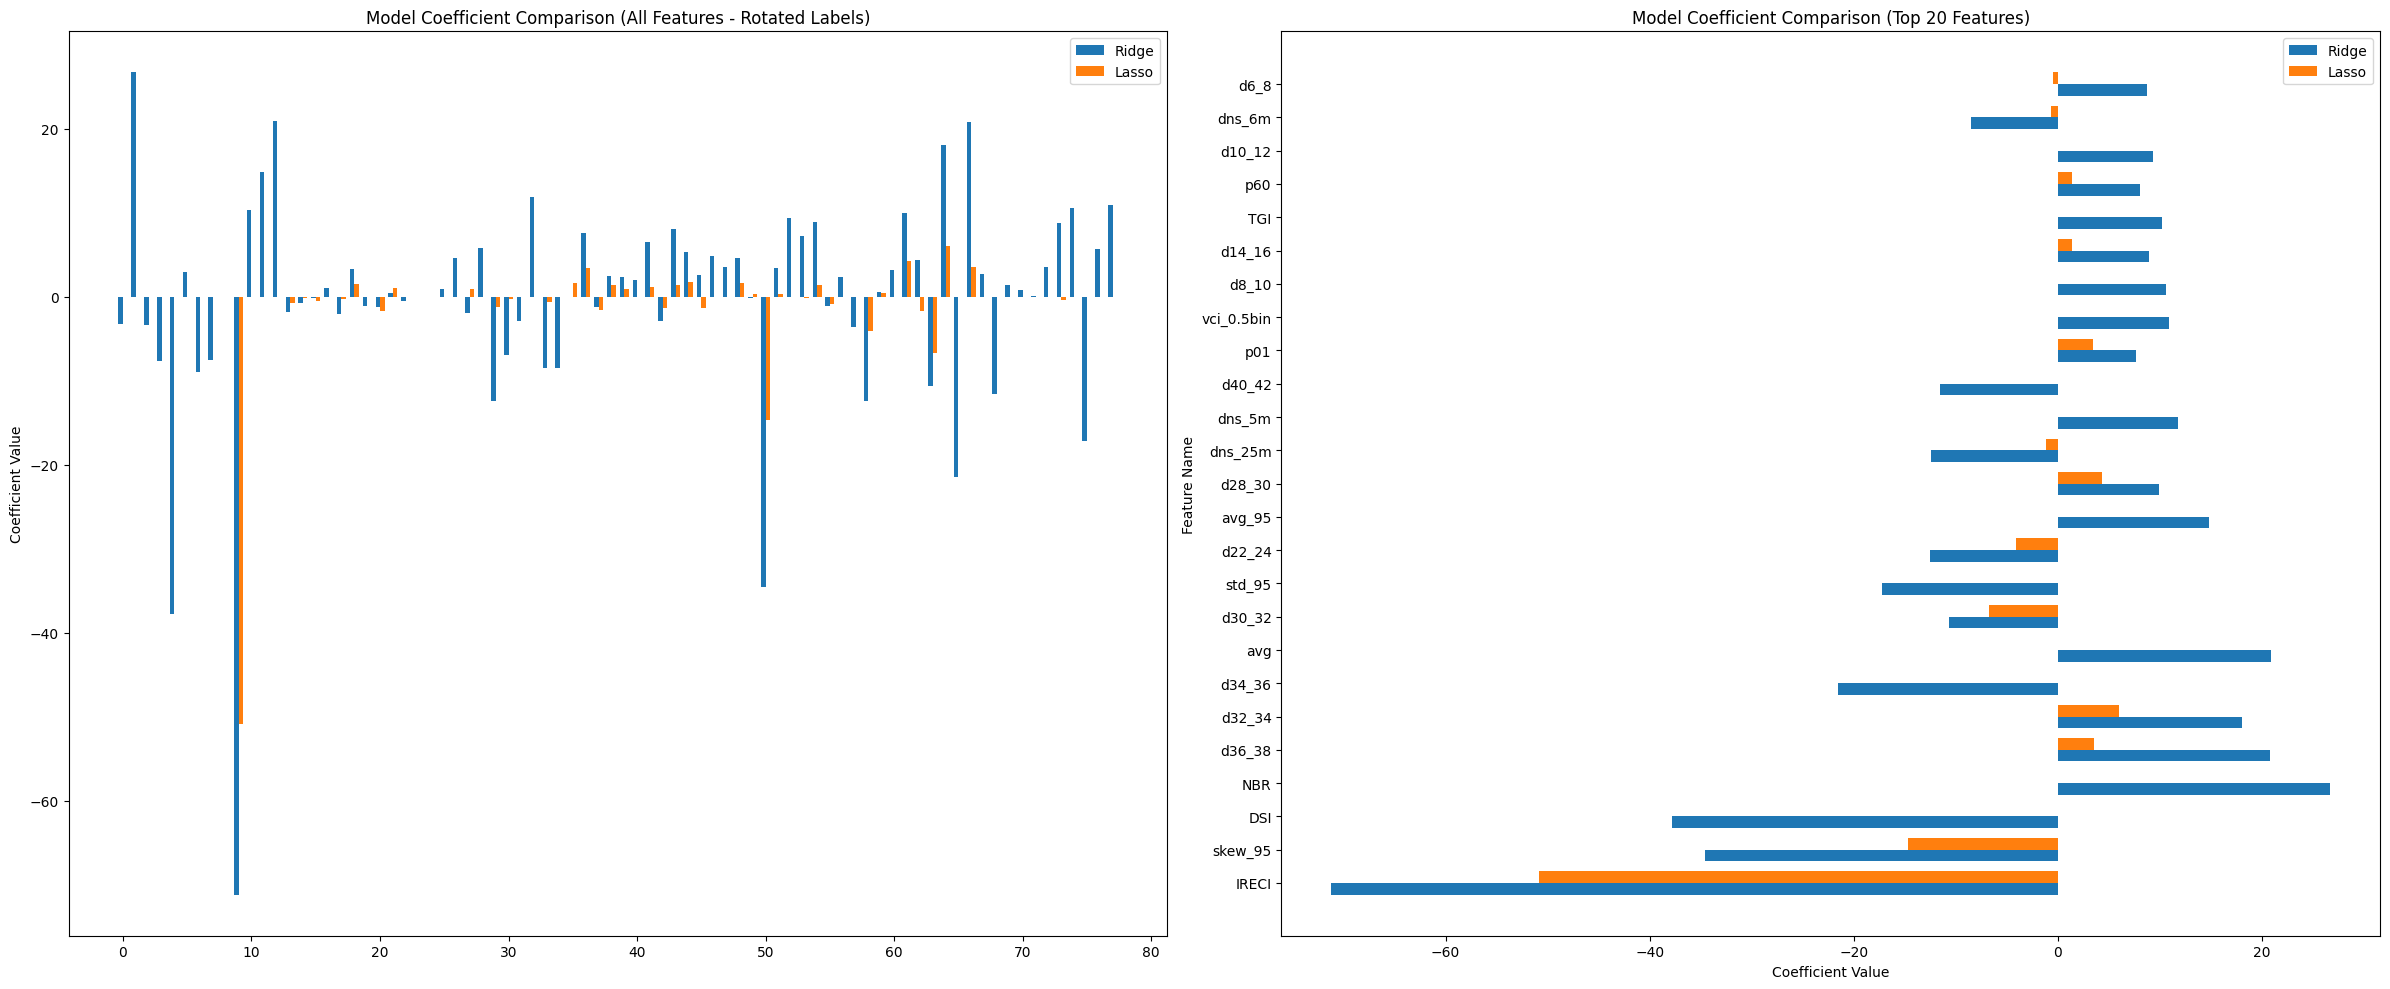

In [44]:
# @title Solution
feature_names =  ['NDVI', 'NBR', 'SAVI', 'MSAVI', 'DSI', 'NDWI', 'GLI', 'ND705', 'NDREI', 'IRECI', 'TGI', 'avg_95', 'avg', 'b10', 'b20', 'b30', 'b40', 'b50', 'b60', 'b70', 'b80', 'b90', 'dns_10m', 'dns_12m', 'dns_14m', 'dns_15m', 'dns_16m', 'dns_18m', 'dns_20m', 'dns_25m', 'dns_2m', 'dns_4m', 'dns_5m', 'dns_6m', 'dns_8m', 'kur_95', 'p01', 'p05', 'p10', 'p20', 'p30', 'p40', 'p50', 'p60', 'p70', 'p80', 'p90', 'p95', 'p99', 'qav', 'skew_95', 'd0_2', 'd10_12', 'd12_14', 'd14_16', 'd16_18', 'd18_20', 'd20_22', 'd22_24', 'd24_26', 'd26_28', 'd28_30', 'd2_4', 'd30_32', 'd32_34', 'd34_36', 'd36_38', 'd38_40', 'd40_42', 'd42_44', 'd44_46', 'd46_48', 'd4_6', 'd6_8', 'd8_10', 'std_95', 'vci_1mbin', 'vci_0.5bin']

ridge_coef = ridge.coef_
lasso_coef = lasso.coef_

x = np.arange(len(feature_names))
width = 0.35

fig, axes = plt.subplots(1, 2, figsize=(24, 10))

# Plot 1
# Use axes[0] for the first subplot
axes[0].bar(x - width/2, ridge_coef, width, label='Ridge')
axes[0].bar(x + width/2, lasso_coef, width, label='Lasso')
axes[0].set_ylabel("Coefficient Value")
axes[0].set_title("Model Coefficient Comparison (All Features - Rotated Labels)")
axes[0].legend()


# Prep data for top 20 coefs
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Ridge_Coef': ridge_coef,
    'Lasso_Coef': lasso_coef
})

coef_df['Abs_Sum_Coef'] = np.abs(coef_df['Ridge_Coef']) + np.abs(coef_df['Lasso_Coef'])
coef_df = coef_df.sort_values(by='Abs_Sum_Coef', ascending=False).head(25)

top_feature_names = coef_df['Feature'].tolist()
top_ridge_coef = coef_df['Ridge_Coef'].tolist()
top_lasso_coef = coef_df['Lasso_Coef'].tolist()

x_top = np.arange(len(top_feature_names))

# Plot 2
# Use axes[1] for the second subplot
axes[1].barh(x_top - width/2, top_ridge_coef, width, label='Ridge')
axes[1].barh(x_top + width/2, top_lasso_coef, width, label='Lasso')

axes[1].set_xlabel("Coefficient Value")
axes[1].set_ylabel("Feature Name")
axes[1].set_title("Model Coefficient Comparison (Top 20 Features)")
axes[1].legend()
axes[1].set_yticks(x_top)
axes[1].set_yticklabels(top_feature_names, fontsize=10)

plt.tight_layout()
plt.show()

These types of graphs show the coefficients for each predictor and how each model penalized them.  
An important concept to remember is that simpler models are generally preferred in machine learning, as they tend to avoid overfitting and perform better on real-world data.

If Lasso eliminates many irrelevant variables, it results in a simpler model.  
If this simplification leads to better performance compared to Ridge, it suggests that Lasso is the superior model overall.  
However, we cannot draw this conclusion from the chart alone.  
By examining the evaluation metrics from the final section of this goal, we can incorporate this information into our final decision.

Finally, lets look at the RMSE (Root Mean Squared Error) and R² (Coefficient of Determination) values.

In [45]:
def print_metrics(name, y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{name} - RMSE: {rmse:.3f}, R²: {r2:.3f}")

print_metrics("Ridge", y_test, y_test_pred_ridge)
print_metrics("Lasso", y_test, y_test_pred_lasso)

Ridge - RMSE: 87.045, R²: 0.260
Lasso - RMSE: 74.039, R²: 0.465


The RMSE (Root Mean Squared Error) is lower for the Lasso model, indicating that its predictions are, on average, closer to the actual values.

The R² (Coefficient of Determination) is higher for Lasso, meaning it explains a greater proportion of the variance in the response variable (`biomass_Mg_ha`). Specifically, Lasso explains 46.5% of the variance, whereas Ridge explains only 26%.

These results suggest that Lasso is the better model in this case, as it fits the data more accurately and generalizes more effectively.

**Question 3 - After our obervations, which model do you think is better to use for the final prediction?**

<details open>
<summary>Solution</summary>

Based on our observations, the Lasso regression model appears to be the better choice for the final prediction. It achieves a lower RMSE, indicating more accurate predictions, and a higher R² value, meaning it explains a larger proportion of the variance in the target variable (`biomass_Mg_ha`). Additionally, Lasso's ability to perform variable selection and produce a simpler model reduces the risk of overfitting and improves generalizability. Therefore, Lasso is preferred over Ridge for this dataset.

</details>

# Goal 3: Apply the best performing model for each response variable across the entire PRF

We will use cross-validation to search for the optimal value of the regularization parameter alpha for our Lasso model. This process will help improve model performance by selecting the alpha that best balances bias and variance. We achieve this by evaluating multiple candidate alpha values and choosing the one that yields the best cross-validated score.

**Note: this code might take some time to run, and disregard any warnings.**

In [46]:
from sklearn.model_selection import GridSearchCV

In [ ]:
full_df = pd.concat([..., ...], axis=1)
full_df_clean = test_df.dropna()

# Separate features and target again
X = full_df_clean[predictor_vars]
y = full_df_clean[target_var]


alphas = np.logspace(-3, 3, 300)
lasso_cv = ...(Lasso(max_iter=10000), param_grid={'alpha': alphas}, scoring='neg_mean_squared_error', cv=5)
lasso_cv.fit(X_train, y_train)

In [47]:
# @title Solution
alphas = np.logspace(-3, 3, 300)
lasso_cv = GridSearchCV(Lasso(max_iter=10000), param_grid={'alpha': alphas}, scoring='neg_mean_squared_error', cv=5)
lasso_cv.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.772e+04, tolerance: 8.977e+01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.205e+04, tolerance: 8.534e+01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.467e+04, tolerance: 9.325e

GridSearchCV(cv=5, estimator=Lasso(max_iter=10000),
             param_grid={'alpha': array([1.00000000e-03, 1.04728984e-03, 1.09681601e-03, 1.14868426e-03,
       1.20300535e-03, 1.25989528e-03, 1.31947552e-03, 1.38187331e-03,
       1.44722187e-03, 1.51566076e-03, 1.58733611e-03, 1.66240098e-03,
       1.74101565e-03, 1.82334800e-03, 1.90957383e-03, 1.99987727e-03,
       2.09445114e-03, 2.19349740e-03, 2.2...
       3.45510729e+02, 3.61849876e+02, 3.78961698e+02, 3.96882735e+02,
       4.15651256e+02, 4.35307336e+02, 4.55892950e+02, 4.77452054e+02,
       5.00030684e+02, 5.23677054e+02, 5.48441658e+02, 5.74377375e+02,
       6.01539588e+02, 6.29986298e+02, 6.59778248e+02, 6.90979055e+02,
       7.23655342e+02, 7.57876886e+02, 7.93716762e+02, 8.31251499e+02,
       8.70561248e+02, 9.11729948e+02, 9.54845510e+02, 1.00000000e+03])},
             scoring='neg_mean_squared_error')

In [48]:
lasso_opt = Lasso(alpha=lasso_cv.best_params_['alpha'], max_iter=10000)
lasso_opt.fit(X_train, y_train)

Lasso(alpha=np.float64(11.846187309026847), max_iter=10000)

Lets make our final prediction!

In [49]:
y_pred_full = lasso_opt.predict(X_test)

There are a few ways we can visulize our results. Lets go through them!

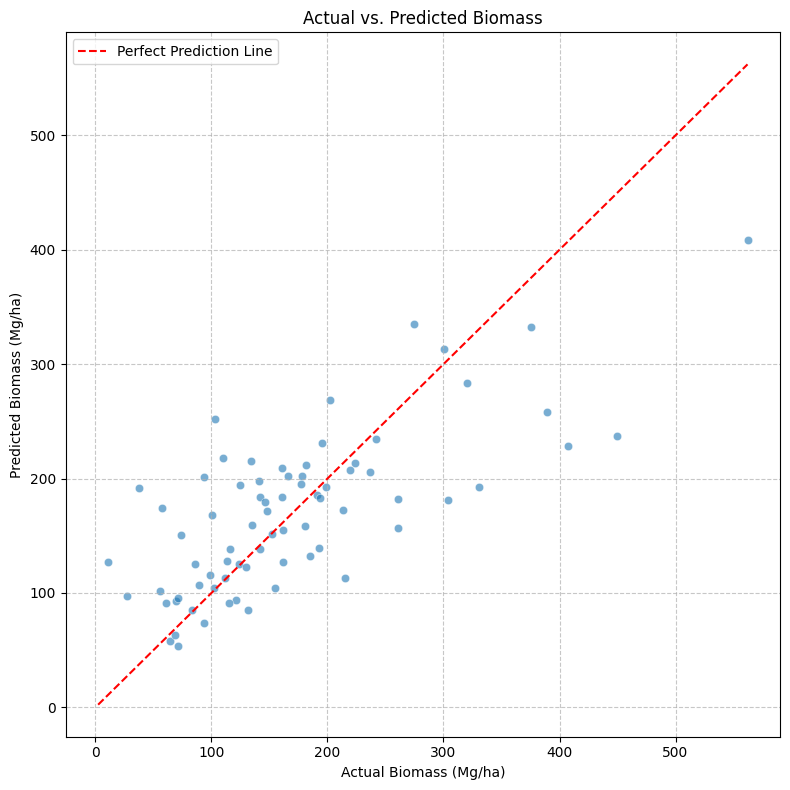

In [52]:
plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_test, y=y_pred_full, alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', linestyle='--', label='Perfect Prediction Line') # y=x line
plt.title('Actual vs. Predicted Biomass')
plt.xlabel('Actual Biomass (Mg/ha)')
plt.ylabel('Predicted Biomass (Mg/ha)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Like how we seen before, an Actual vs Predicted graph is always good to see at a quick glance how our model preformed. Below lets print out the metrics to compare this final model quantitatively.

In [51]:
print_metrics("Lasso CV", y_test, y_pred_full)

Lasso CV - RMSE: 69.041, R²: 0.535


**Question 1 -** Given that our model now achieves a higher R² and a lower RMSE compared to previous trial sets, does this indicate that the model’s performance has improved or deteriorated?

*Answer here*

<details open>
<summary>Solution</summary>

While there is improvment in having a higher R² and lower RMSE, it is marginal. However any improvment is welcomed and thus our model has imporved!

</details>

Lets create a redisdual plot. To do this, you must calculate the difference between the predicted `y_pred_full` from the actual `y_test` values.

**Question 2 - fill in the code below.**

In [ ]:
residuals = ... - ...

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred_full, y=residuals, alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--', label='Zero Residual Line') # Zero error line
plt.title('Residuals Plot (Predicted vs. Residuals)')
plt.xlabel('Predicted Biomass (Mg/ha)')
plt.ylabel('Residuals (Actual - Predicted)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

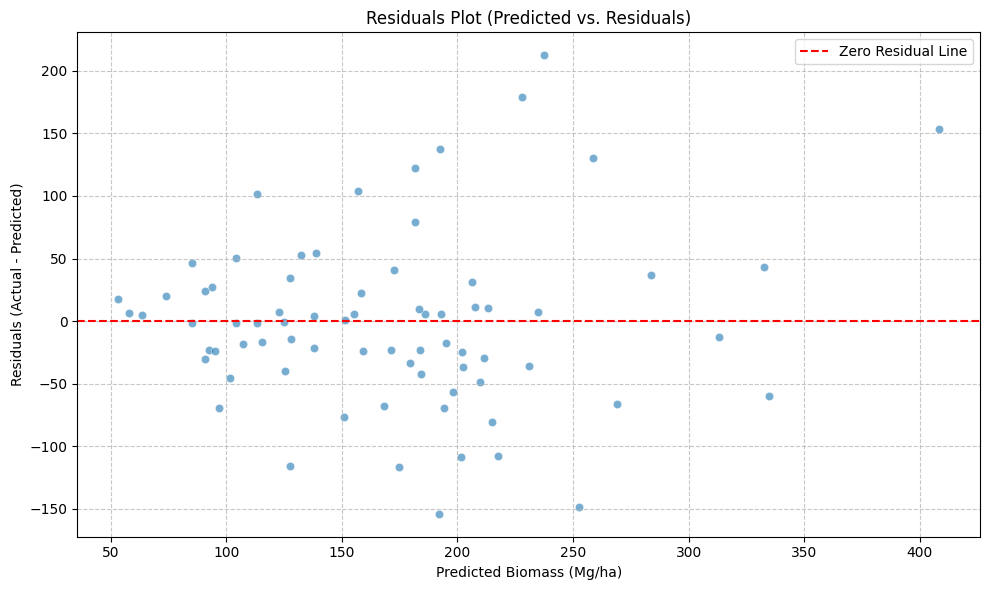

In [ ]:
# @title Solution
residuals = y_test - y_pred_full

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred_full, y=residuals, alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--', label='Zero Residual Line') # Zero error line
plt.title('Residuals Plot (Predicted vs. Residuals)')
plt.xlabel('Predicted Biomass (Mg/ha)')
plt.ylabel('Residuals (Actual - Predicted)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

A residual plot is useful for detecting any patterns or trends in the residuals.  
We do **not** want to observe any trends, as their presence can indicate multicollinearity among variables, which is undesirable.  
Ideally, the residuals should be randomly and evenly dispersed, as demonstrated once the plot above is generated.

Now run the code below to see the final sets of graphs.

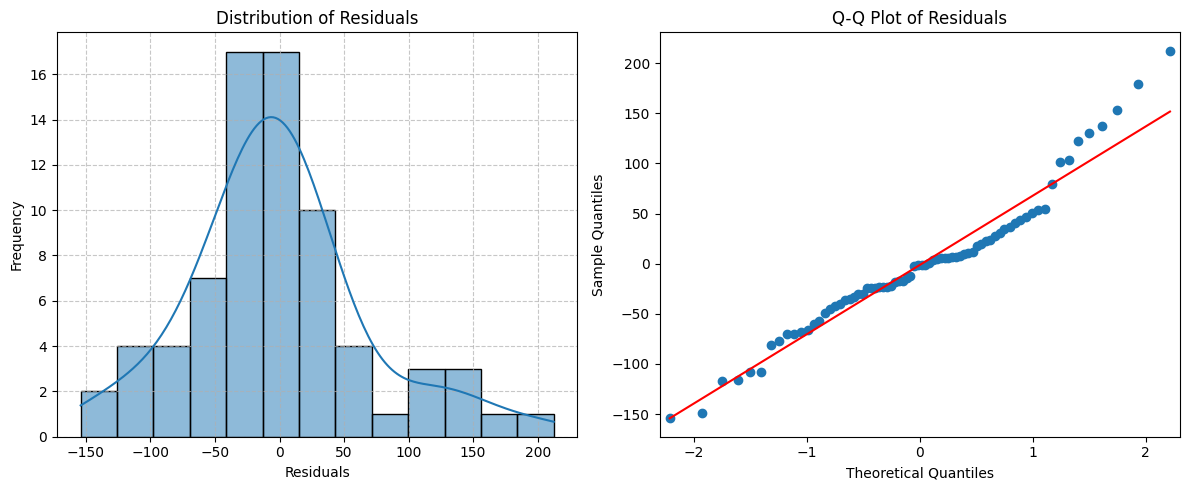

In [ ]:
# Set up side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Histogram with KDE
sns.histplot(residuals, kde=True, ax=axes[0])
axes[0].set_title('Distribution of Residuals')
axes[0].set_xlabel('Residuals')
axes[0].set_ylabel('Frequency')
axes[0].grid(True, linestyle='--', alpha=0.7)

# Q-Q plot
sm.qqplot(residuals, line='s', ax=axes[1])
axes[1].set_title('Q-Q Plot of Residuals')

plt.tight_layout()
plt.show()

Looking at the histogram below, the residuals should ideally form a bell-shaped distribution (approximately normal) centered around zero.  

Regarding the Q-Q plot, if the points largely follow the straight reference line, it suggests that the residuals are approximately normally distributed.  
Deviations from this line indicate departures from normality. Both of these graphs can help determine that out experiment falls into line what should be expected of a good result.

To summarize, we now have our final model, and we have confirmed that the results align with what we expect from a well-performing model based on the residual trends. Lasso regression was chosen for this dataset due to its superior performance in this case. However, this does not imply that Ridge regression is an inferior model; depending on the dataset, Ridge may perform better. Therefore, it is always advisable to test multiple regression methods for any analysis.

Furthermore, if new data similar to this set becomes available, we can use our final model to predict the overall `biomass_Mg_ha`. This encapsulates the main objective of our work here.
